# Time Comparison Model
Given a game with **12**-month data. Here we build our model to study how games with similar **12**-month history behave in the next **6**-month with all our data in hand. Parameters are chosen based on Cross Validation computed in the TS_ModelExp notebook. For more explanations on the algorithm, please refer to the TS_ModelExp notebook as well.

In [1]:
import pandas as pd
import numpy as np

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing

In [2]:
np.arange(500,1100,50)

array([ 500,  550,  600,  650,  700,  750,  800,  850,  900,  950, 1000,
       1050])

### Load in all data from the DataPreparation notebook

In [3]:
data = pd.read_csv('data18m.csv', index_col=0)
data_pure = data.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days', 'max', 'birth']).astype(float)

In [4]:
# Making a list of first 12 month data
def get_values(data):
    original = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        months = pd.to_datetime(game_data.index)
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()].values
        original.append(temp)
    return original

In [5]:
original_data = get_values(data_pure)

### Metric

Define the metric and weight using l2 norm and Gaussian kernel.

In [6]:
def rootmse(a, b):
    return np.sqrt(np.sum((a-b)**2))

def Gauss_weight(a, b, epsilon = 20):
    return np.exp(-epsilon*rootmse(a,b)**2)

To compare the shape of 2 curves, we want to compute the scalar that makes 2 curves close together by scaling only.

In [7]:
def mini_scaler(a,b):
    return np.sum(a*b)/np.sum(a**2)

### Smoothing
Exponential Smoothing with smoothing level = .6

In [8]:
# Getting the smoothed curve for each game
# Ordered in increasing time order.

def smooth_values(data, smoothing_level=.6):
    smooth_timedata = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        months = pd.to_datetime(game_data.index)
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()]
    
        # Fit exponential smoothing
        ses = SimpleExpSmoothing(temp.values)
        fit = ses.fit(smoothing_level=smoothing_level, optimized=False)

        smooth_timedata.append(fit.fittedvalues)
        
    return smooth_timedata

Getting the smoothed data:

In [9]:
smooth_data = smooth_values(data_pure)

C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [10]:
# For faster computation time used in the app version
#pd.DataFrame(smooth_data).to_csv('Smooth_data18m_pure.csv')
#pd.DataFrame(original_data).to_csv('original_data18m_pure.csv')

### Main Algorithm

In [11]:
def wt_avg(game, smooth_game, data, smooth_data, metric = Gauss_weight, epsilon = 20, threshold=0.8, horizon = 6):
    length = len(game)
    smooth_length = len(smooth_game)
    if np.max(np.abs(smooth_game))!=0:
        smooth_game_scaled = smooth_game / rootmse(smooth_game,0)
    else:
        smooth_game_scaled = smooth_game
    pred = np.zeros(length+horizon)
    close_index = np.zeros((len(data),2))
    j=0
    for i in range(len(data)):
        temp = data[i]
        smooth_temp = smooth_data[i]
        if len(temp)>=length+horizon:
            if np.max(np.abs(temp[:length]))!=0:
                temp_scaled = temp * mini_scaler(temp[:length],game)
            else:
                temp_scaled = temp
            if np.max(np.abs(smooth_temp[:smooth_length]))!=0:
                smooth_temp_scaled = smooth_temp * mini_scaler(smooth_temp[:smooth_length],smooth_game_scaled)
            else:
                smooth_temp_scaled = smooth_temp
            weight=metric(smooth_game_scaled,smooth_temp_scaled[:smooth_length], epsilon = epsilon)
            if weight >= threshold:
                pred = pred + weight * temp_scaled[:length+horizon]
                close_index[j]=[i,weight]
                j=j+1
    if np.max(np.abs(pred[:length])) !=0:
        pred = pred * mini_scaler(pred[:length],game)
    else:
        pred = np.ones(length + horizon) * smooth_game[-1]
    close_index = close_index[:j]
    close_index = close_index[np.argsort(close_index[:, 1])][::-1]
    return pred, close_index

# Time Comparison Function

The model is default for observing how games with similar **12**-month history behave in the next **6**-month and the parameters are optimized for such choice. However the user can enter data of any length and change the horizon for observation.

Input: 
- average number of players in first n months of a game
- format: nonnegative array of length n.


Output: 
- weighted average of the average number of players of m months.
- a list of close games arranged in decreasing weight.
- plot of weighted average and some close games.

In [12]:
def ult_pred(game, train = original_data, smooth_train = smooth_data, real_data = [], plot = True, number=3, threshold = 0.8, horizon = 6):
    ses = SimpleExpSmoothing(game)
    fit = ses.fit(smoothing_level=.6, optimized=False)
    smooth_game = fit.fittedvalues
    [pred, close_index] = wt_avg(game, smooth_game, train, smooth_train, threshold = threshold, horizon = horizon)
    while (len(close_index)<=2 and threshold >= 0.5):
        threshold = threshold - 0.1
        [pred, close_index] = wt_avg(game, smooth_game, train, smooth_train, threshold = threshold, horizon = horizon)
    if plot:
        #plt.style.use('dark_background')
        plt.figure(figsize=(12,12))
        plt.plot(range(1,len(game)+horizon + 1), pred, color='red', linestyle = '--', label = 'Weighted Average')
        plt.plot(range(1,len(game)+1), game, 'b', label = 'Your Game Data')
        if len(real_data) !=0:
            plt.plot(range(len(game),len(game)+ horizon +1), real_data, color = 'b', linestyle = '--', label = 'Your Test Data')
        if len(close_index)!=0:
            plot_range = range(min(number,len(close_index)))
            for i in plot_range:
                close_game = train[int(close_index[i][0])][:len(game)+horizon]
                scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
                plt.plot(range(1,len(game)+horizon +1), scaled_close_game, label = str(i+1)+'-th closest scaled Game: ' + str(data.iloc[int(close_index[i][0])]['Name']) + ' , weight = ' + str(close_index[i][1]))

        plt.legend(fontsize=12)
        plt.xlabel('Age (Months)')
        plt.ylabel('Average Players scaled according to Test Game')
        plt.title(str(horizon)+'-month Observation given '+str(len(game))+'-month data')
        plt.show()
    return pred, close_index

### Imaginary Examples:

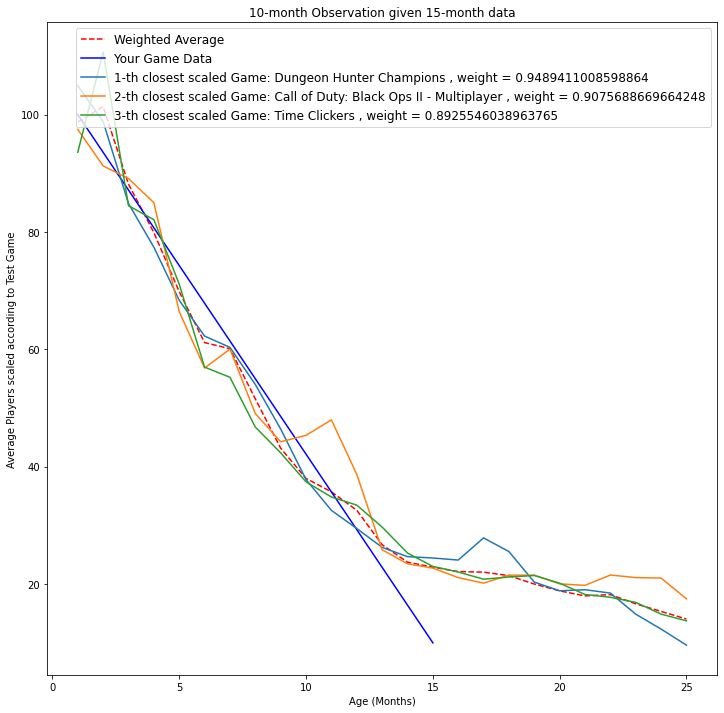

In [13]:
game = np.linspace(100,10,15)
[pred, close_index]=ult_pred(game, horizon = 10)

C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


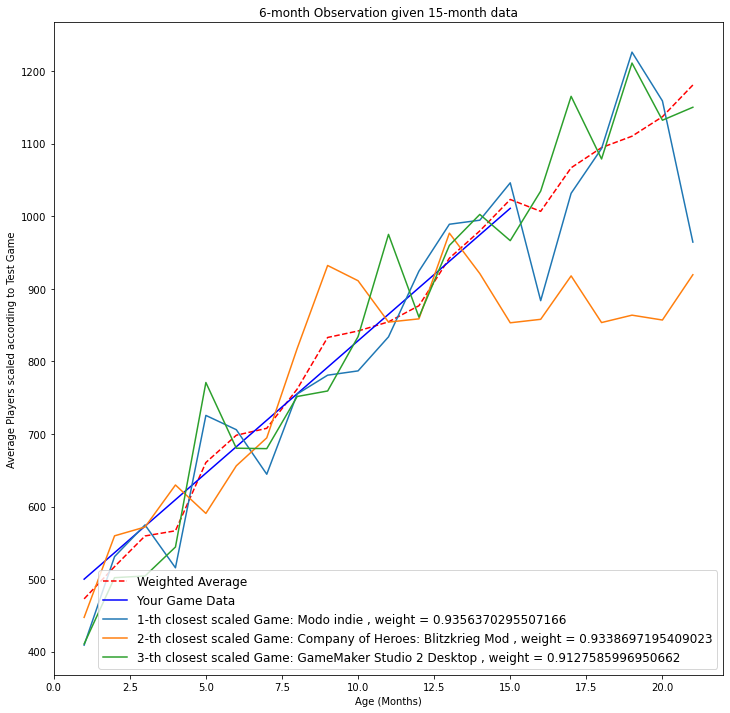

In [14]:
game = np.linspace(500,1011,15)

[pred, close_index]=ult_pred(game)

### Real Examples in our data base:
Pick a game A in our data base and only use its first 12-month data. Suppose you want to use everything except game A for comparison.

Example 1: Among Us

In [15]:
data.loc[data['Name']=='Among Us']

,Name,App_id,Avg_Players,Gain,Perc_Gain,Peak_Players,Last 30 Days,April 2021,March 2021,February 2021,...,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012,max,birth
51,Among Us,945360,1.0,0.0,0.0,0.0,12238.26,19749.26,16490.54,24485.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176453.91,November 2018


C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


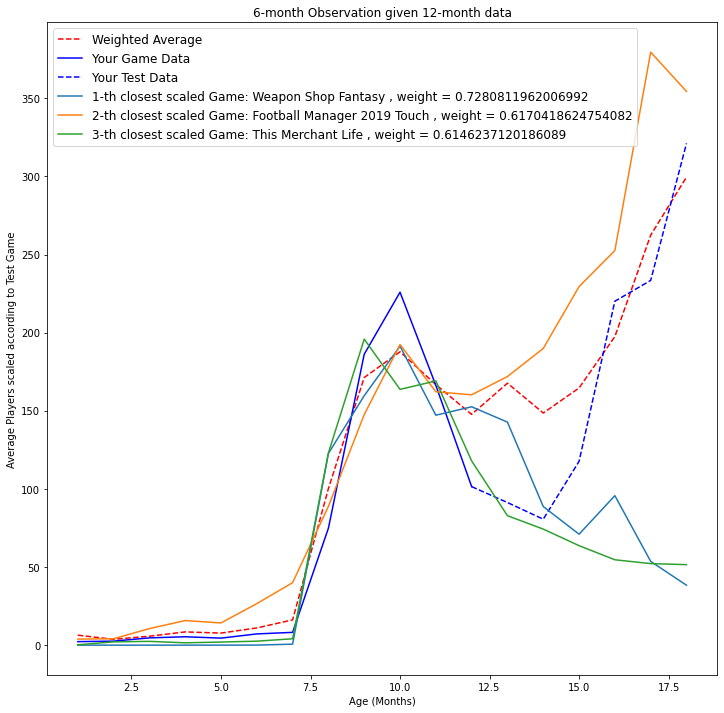

In [16]:
name = 'Among Us'

game = original_data[data.loc[data['Name']==name].index[0]][:12]
real_data = original_data[data.loc[data['Name']==name].index[0]][11:18]

subdata = original_data.copy()
del subdata[data.loc[data['Name']==name].index[0]]
smooth_subdata = smooth_data.copy()
del smooth_subdata[data.loc[data['Name']==name].index[0]]

[pred, close_index] = ult_pred(game, train = subdata, smooth_train = smooth_subdata, real_data = real_data)

Example 2: Grand Theft Auto V

In [17]:
data.loc[data['Name']=='Grand Theft Auto V']

,Name,App_id,Avg_Players,Gain,Perc_Gain,Peak_Players,Last 30 Days,April 2021,March 2021,February 2021,...,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012,max,birth
1,Grand Theft Auto V,271590,1.0,0.0,0.0,0.0,85098.54,92647.8,89792.84,90647.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192714.01,April 2015


C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


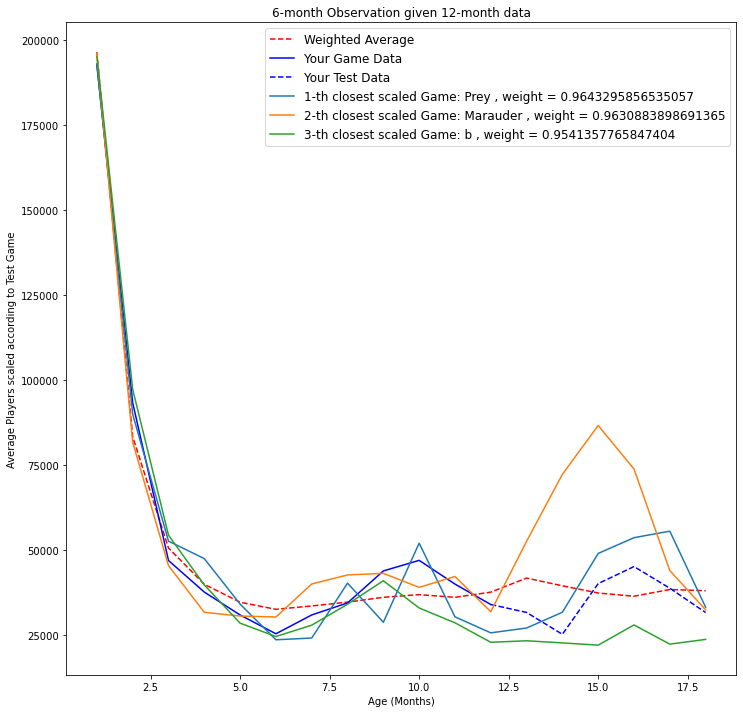

In [18]:
name = 'Grand Theft Auto V'

game = original_data[data.loc[data['Name']==name].index[0]][:12]
real_data = original_data[data.loc[data['Name']==name].index[0]][11:18]

subdata = original_data.copy()
del subdata[data.loc[data['Name']==name].index[0]]
smooth_subdata = smooth_data.copy()
del smooth_subdata[data.loc[data['Name']==name].index[0]]

[pred, close_index] = ult_pred(game, train = subdata, smooth_train = smooth_subdata, real_data = real_data)